In [13]:
!pip install tensorflow keras-tuner pandas numpy matplotlib scikit-learn


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import keras_tuner as kt


In [15]:
np.random.seed(42)

time_steps = 1500

# Create base signal (trend + seasonality)
trend = np.linspace(0, 10, time_steps)
seasonality = 2 * np.sin(np.linspace(0, 50, time_steps))
noise = np.random.normal(0, 0.5, time_steps)

data = trend + seasonality + noise

# Inject anomalies
anomaly_indices = np.random.choice(range(200, 1300), 25, replace=False)
data[anomaly_indices] += np.random.uniform(6, 10, size=len(anomaly_indices))

# Create DataFrame
df = pd.DataFrame({
    "time": range(time_steps),
    "value": data
})

df.head()


,time,value
0,0,0.248357
1,1,0.004238
2,2,0.470510
3,3,0.981328
4,4,0.175661


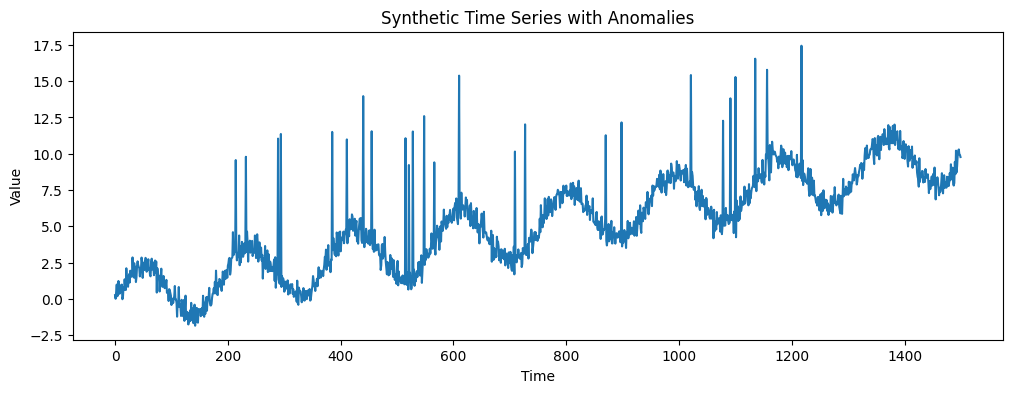

In [16]:
plt.figure(figsize=(12,4))
plt.plot(df["value"])
plt.title("Synthetic Time Series with Anomalies")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


In [17]:
scaler = MinMaxScaler()

data_scaled = scaler.fit_transform(df[["value"]])


In [18]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

WINDOW_SIZE = 30

X, y = create_sequences(data_scaled, WINDOW_SIZE)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1470, 30, 1)
y shape: (1470, 1)


In [19]:
split_index = int(0.8 * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [20]:
def build_model(hp):
    model = keras.Sequential()

    rnn_type = hp.Choice("rnn_type", ["LSTM", "GRU"])
    units = hp.Int("units", min_value=32, max_value=128, step=32)

    if rnn_type == "LSTM":
        model.add(layers.LSTM(units, input_shape=(WINDOW_SIZE, 1)))
    else:
        model.add(layers.GRU(units, input_shape=(WINDOW_SIZE, 1)))

    model.add(layers.Dense(1))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        ),
        loss="mse"
    )

    return model


In [21]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=6,
    executions_per_trial=1,
    directory="nas_dir",
    project_name="time_series_project"
)

tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)


Trial 6 Complete [00h 00m 11s]
val_loss: 0.005642241798341274

Best val_loss So Far: 0.00548504339531064
Total elapsed time: 00h 01m 14s


In [22]:
best_model = tuner.get_best_models(num_models=1)[0]

history = best_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=32
)


Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0037 - val_loss: 0.0056
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0045 - val_loss: 0.0069
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0040 - val_loss: 0.0071
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0051 - val_loss: 0.0072
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0048 - val_loss: 0.0056
Epoch 9/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0036 - val_loss: 0.0070
Epoch 10/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0048 - val_loss: 0.0055
Epoch 11/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 12/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0058 - val_l

In [28]:
!pip install anomalies

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/tmp/ipython-input-3802329723.py:10: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  anomaly_points = np.where('anomalies')[0]


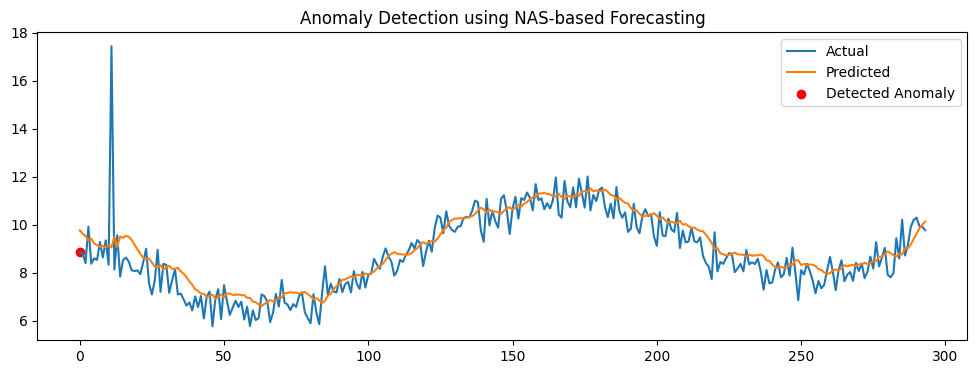

In [33]:
predictions = best_model.predict(X_test)

# Inverse scaling
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)
plt.figure(figsize=(12,4))
plt.plot(y_test_rescaled, label="Actual")
plt.plot(predictions_rescaled, label="Predicted")

anomaly_points = np.where('anomalies')[0]
plt.scatter(
    anomaly_points,
    y_test_rescaled[anomaly_points],
    color="red",
    label="Detected Anomaly"
)

plt.legend()
plt.title("Anomaly Detection using NAS-based Forecasting")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [25]:
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
rmse


np.float64(0.8103667308015786)

In [32]:
best_model.save("nas_time_series_anomaly_model.h5")
